# EXPLORATION OF TCIA QIN-HEADNECK DATA COLLECTION

This is a Jupyter Notebook that demonstrates how Python can be used to explore the content of a publicly available DICOM dataset stored on The Cancer Imaging Archive (TCIA) and described here: https://wiki.cancerimagingarchive.net/display/Public/QIN-HEADNECK. 

This notebook was created as part of the preparations to the [DICOM4MICCAI tutorial](http://qiicr.org/dicom4miccai) at the [MICCAI 2017 conference](https://miccai2017.org) on Sept 10, 2017. 

The tutorial was organized by the [Quantitative Image Informatics for Cancer Research (QIICR)](http://qiicr.org) project funded by the [Informatics Technology for Cancer Research (ITCR)](https://itcr.nci.nih.gov/) program of the National Cancer Institute, award U24 CA180918.

More pointers related to the material covered in this notebook:

* DICOM4MICCAI gitbook https://qiicr.gitbooks.io/dicom4miccai-handson
* dcmqi: conversion between DICOM and quantitative image analysis results https://github.com/QIICR/dcmqi
* QIICR project GitHub organization: https://github.org/QIICR
* QIICR home page: http://qiicr.org

## Feedback

Questions, comments, suggestions, corrections are welcomed!

Please email `andrey.fedorov@gmail.com`, or [join the discussion on gitter]( https://gitter.im/QIICR/dcmqi)!

## Table of Contents

* <a href="#Introduction-and-prerequisites">Introduction and prerequisites</a>
* <a href="#Dataset-overview">Dataset overview</a>

* <a href="#Further-reading">Further reading</a>

## Introduction and prerequisites

The goal of this tutorial is to demonstrate how Python can be used to work with the data produced by quantitative image analysis and stored using the DICOM format. 

You don't need to know much about DICOM to follow along, but you will need to learn more about it if you want to adopt it in your work. You will find pointers in the <a href="#Further-reading">Further reading</a> section.

# Dataset overview

The dataset used in this tutorial is discussed in detail in this publication:

> Fedorov A., Clunie D., Ulrich E., Bauer C., Wahle A., Brown B., Onken M., Riesmeier J., Pieper S., Kikinis R., Buatti J., Beichel RR. _DICOM for quantitative imaging biomarker development: a standards based approach to sharing clinical data and structured PET/CT analysis results in head and neck cancer research_. PeerJ 4:e2057, 2016. DOI: [10.7717/peerj.2057](https://dx.doi.org/10.7717/peerj.2057)

Here is a bird's eye view of the QIN-HEADNECK dataset: 
* 156 subjects with head and neck cancer
* each subject had one or more PET/CT study (each study is expected to include a CT and a PET imaging series) for disease staging and treatment response assessment
* images for a subset of 59 subjects were analyzedas follows:
 * primary tumor and the involved lymph nodes were segmented by each of the two readers, on two occasions, using [3D Slicer](http://slicer.org) both manually and using an interactive automated segmentation tool described in [this publicly available paper](http://onlinelibrary.wiley.com/doi/10.1118/1.4948679/full)
 * the following reference regions used for PET normalization were segmented using automatic tools: cerebellum, liver and aortic arch
 * all segmentations were saved as DICOM Segmentation objects
 * quantitative measurements were calculated from the PET images after applying Standardized Uptake Value (SUV) normalilzation for all the regions defined by the segmentations
 * all resulting measurements were saved as DICOM Structured Report obects following [DICOM SR Template 1500](http://dicom.nema.org/medical/dicom/current/output/chtml/part16/chapter_A.html#sect_TID_1500)
   
![](https://dfzljdn9uc3pi.cloudfront.net/2016/2057/1/fig-1-2x.jpg)


The DICOM dataset was converted into a collection of tables using this converter script: https://github.com/QIICR/dcm2tables. The script extracts data elements from the DICOM files and stores them as a collection of tab-delimited text files that follow [this schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw).

## Tools

In this demonstration we will use the following Python packages:
* Pandas for working with the tabular data
* numpy for numerical operations
* [matplotlib](https://matplotlib.org/index.html), [seaborn](https://seaborn.pydata.org/) and [bokeh](http://bokeh.pydata.org/en/latest/) for plotting

If you are working with this notebook on your own system, you will need to install those packages as a prerequisite to import the packages!

## Data

You can download the collection of the extracted tables here: https://github.com/fedorov/dicom4miccai-handson/releases/download/untagged-f8d939ebd97e5895e439/QIN-HEADNECK-tables.zip. Unzip the file, note the location of the resulting directory, and set the value of the variable below to that location.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
tablesPath = '/home/jovyan/data/QIN-HEADNECK-tables'
#tablesPath = '/Users/fedorov/Dropbox (Partners HealthCare)/ImageData/QIICR/QIN-HEADNECK/QIN-HEADNECK-tables-no_clinical/'

In [9]:
CompositeContext_df=pd.read_csv(tablesPath+'/CompositeContext.tsv', sep='\t',low_memory=False)
CompositeContext_df.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

In [10]:
SR_df = pd.read_csv(tablesPath+'/SR.tsv', sep='\t', low_memory=False)
SR1500_MeasurementGroups_df = pd.read_csv(tablesPath+'/SR1500_MeasurementGroups.tsv', sep='\t', low_memory=False)
SR1500_Measurements_df = pd.read_csv(tablesPath+'/SR1500_Measurements.tsv', sep='\t', low_memory=False)

In [11]:
SR_merged = pd.merge(SR1500_Measurements_df,SR1500_MeasurementGroups_df,on=["SOPInstanceUID","TrackingUniqueIdentifier"])
SR_merged.shape

(12891, 24)

In [12]:
SR_merged=pd.merge(SR_merged, CompositeContext_df, on="SOPInstanceUID")
SR_merged.shape

(12891, 42)

In [13]:
SR_merged["segmentationToolType"] = \
 SR_merged["SeriesDescription"].apply(lambda toolType: toolType.split(" ")[-3] if toolType.split(" ")[-3] in ["Manual","SemiAuto"] else "Auto")
#SR_merged["segmentationToolType"]

In [14]:
References_df=pd.read_csv(tablesPath+'/References.tsv', sep='\t', low_memory=False)
References_df.columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID'],
      dtype='object')

In [15]:
series_df=CompositeContext_df.drop_duplicates(subset="SeriesInstanceUID")

# All references to SEG (only Measurements point to SEG in our case, 
#  and each SR should point to exactly one SEG!)
segReferences = References_df[References_df["ReferencedSOPClassUID"]=='1.2.840.10008.5.1.4.1.1.66.4']
segReferences = segReferences[["SOPInstanceUID","SeriesInstanceUID"]].rename(columns={"SeriesInstanceUID":"ReferencedSeriesInstanceUID"})
segReferences.shape

(900, 2)

In [16]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool

output_notebook()

volume = []
user = []
method = []
sesssion = []
subject = []

SR_merged = pd.merge(SR_merged, segReferences)


subset = SR_merged[SR_merged["PersonObserverName"]=="User1"]
subset = subset[subset["Finding_CodeMeaning"]=="Neoplasm, Primary"]
subset = subset[subset["quantity_CodeMeaning"]=="Volume"]
#subset = subset[subset["activitySession"]==1]
#subset = subset[subset["segmentationToolType"]=="SemiAuto"]

#subset.sort_values("value", inplace=True)

#subset=subset[subset["PatientID"]=="QIN-HEADNECK-01-0003"]

Loading BokehJS ...

In [18]:
volumes = subset["value"].values
observers = subset["PersonObserverName"].values
subjects = subset["PatientID"].values

subset["segmentationToolType"].unique()

colormap = {'1-Manual': 'red', '2-Manual': 'red', '1-SemiAuto': 'blue', '2-SemiAuto': 'blue'}
colors = [colormap[x] for x in (subset["activitySession"].map(str)+'-'+subset['segmentationToolType']).tolist()]

source = ColumnDataSource(data=dict(
    x=volumes,
    y=subjects,
    color=colors,
    seriesUID=subset["ReferencedSeriesInstanceUID"]
    ))

hover = HoverTool(tooltips=[
    ("(Volume, Subject)", "($x, $y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

p = figure(x_range=[np.min(volumes),np.max(volumes)],y_range=subjects.tolist(), tools = [hover, wZoom, bZoom, reset, tap, pan],title="Volume segmentation consistency by User1; manual (red circles) and SemiAutomatic (blue circles)")
p.yaxis.axis_label = "PatientID"
#p.xaxis.axis_label = subset["quantity_CodeMeaning"].values[0]+', '+subset['units_CodeMeaning'].values[0]

p.circle('x','y',color='color',source=source)

url = "http://pieper.github.com/dcmjs/examples/qiicr/?seriesUID=@seriesUID"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

Let's import the prerequisite packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's load the data!

In [3]:

CompositeContext_df=pd.read_csv(tablesPath+'/CompositeContext.tsv', sep='\t',low_memory=False)
CompositeContext_df.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

As an experiment, let's look over some of the characteristics of the patients that we get from DICOM. Since we have multiple DICOM series/instances for each study, and patient information is the same for all studies, we need to reduce the data first to drop duplicates.

In [4]:
ccPerStudy = CompositeContext_df.drop_duplicates(subset="StudyInstanceUID")

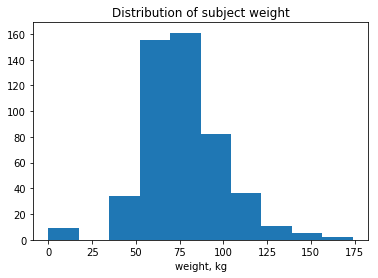

In [5]:
weight = np.nan_to_num(ccPerStudy["PatientWeight"].values)
plt.hist(weight)
plt.xlabel("weight, kg")
plt.title("Distribution of subject weight")
plt.show()

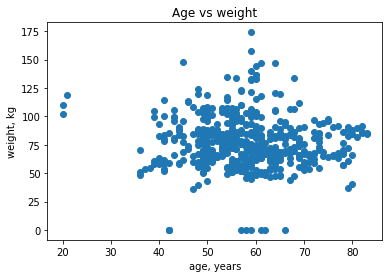

In [6]:
# Age is encoded as 048Y, so we need to strip off the suffix
age = [int(a[:-1]) for a in ccPerStudy["PatientAge"].values]
plt.scatter(age, weight)
plt.xlabel("age, years")
plt.ylabel("weight, kg")
plt.title("Age vs weight")
plt.show()

## Image segmentations

`CompositeContext` table contains information for all DICOM objects, including modality, so we can first confirm how many subjects have segmentations.

In [7]:
# select only those studies that have Segmentations
segSeries = CompositeContext_df[CompositeContext_df["Modality"]=="SEG"].drop_duplicates(subset="StudyInstanceUID")
print("This many studies include segmentations: %i " % (segSeries.shape[0]))
print("This many patients: %i" % segSeries["PatientID"].unique().shape)

This many studies include segmentations: 60 
This many patients: 59


Segmentations are organized as follows: (a fragment from [the overall schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw))

![](https://www.dropbox.com/s/lrcbl895cv64giu/seg_relationships.png?raw=1)

There is a single entry corresponding to each segmentation series in the `SEG` table.

In [8]:
SEG_df = pd.read_csv(tablesPath+'/SEG.tsv', sep='\t', low_memory=False)
SEG_df.head()

,ClinicalTrialSeriesID,ClinicalTrialTimePointID,Columns,ContentCreatorName,NumberOfFrames,Rows,SOPInstanceUID,SegmentationType
0,1,1,512,Automated Aortic Arch Reference Region Segment...,12,512,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,BINARY
1,1,1,128,Automated Cerebellum Reference Region Segmenta...,14,128,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,BINARY
2,1,1,128,Automated Liver Reference Region Segmentation,17,128,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,BINARY
3,1,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,BINARY
4,2,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,BINARY


In [9]:
SEG_df.columns

Index(['ClinicalTrialSeriesID', 'ClinicalTrialTimePointID', 'Columns',
       'ContentCreatorName', 'NumberOfFrames', 'Rows', 'SOPInstanceUID',
       'SegmentationType'],
      dtype='object')

We can merge the `CompositeContext` and `SEG` tables.

In [10]:
SEGSegments_df = pd.read_csv(tablesPath+'/SEG_Segments.tsv', sep='\t', low_memory=False)
SEGSegments_df.head()

,AnatomicRegionSequence_CodeMeaning,AnatomicRegionSequence_CodeValue,AnatomicRegionSequence_CodingSchemeDesignator,SOPInstanceUID,SegmentAlgorithmName,SegmentAlgorithmType,SegmentLabel,SegmentNumber,SegmentedPropertyCategoryCodeSequence_CodeMeaning,SegmentedPropertyCategoryCodeSequence_CodeValue,SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence_CodeMeaning,SegmentedPropertyTypeCodeSequence_CodeValue,SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
0,Aortic arch,T-42300,SRT,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,Iowa QIN Aortic Arch Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
1,Cerebellum,T-A6000,SRT,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,Iowa QIN Cerebellum Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
2,Liver,T-62000,SRT,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,Iowa QIN Liver Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
3,pharyngeal tonsil (adenoid),T-C5300,SRT,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT
4,pharyngeal tonsil (adenoid),T-C5300,SRT,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT


In [11]:
SEGSegments_df.columns

Index(['AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SOPInstanceUID',
       'SegmentAlgorithmName', 'SegmentAlgorithmType', 'SegmentLabel',
       'SegmentNumber', 'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',
       'SegmentedPropertyTypeCodeSequence_CodeValue',
       'SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator'],
      dtype='object')

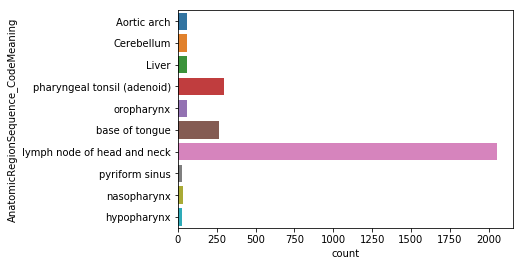

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=SEGSegments_df)

In [13]:
SEG_merged = pd.merge(CompositeContext_df,SEG_df,on="SOPInstanceUID")
SEG_merged = pd.merge(SEG_merged, SEGSegments_df, on="SOPInstanceUID")

In [14]:
SEG_merged.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime',
       'ClinicalTrialSeriesID', 'ClinicalTrialTimePointID', 'Columns',
       'ContentCreatorName', 'NumberOfFrames', 'Rows', 'SegmentationType',
       'AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SegmentAlgorithmName',
       'SegmentAlgorithmType', 'SegmentLabel', 'SegmentNumber',
       'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',
       'SegmentedProper

In [15]:
SEG_merged["SeriesDescription"].value_counts()

tumor segmentation - User3 Manual trial 2      230
tumor segmentation - User3 SemiAuto trial 1    230
tumor segmentation - User2 Manual trial 2      230
tumor segmentation - User1 SemiAuto trial 2    230
tumor segmentation - User2 Manual trial 1      230
tumor segmentation - User3 SemiAuto trial 2    230
tumor segmentation - User2 SemiAuto trial 1    230
tumor segmentation - User2 SemiAuto trial 2    230
tumor segmentation - User1 Manual trial 2      230
tumor segmentation - User3 Manual trial 1      230
tumor segmentation - User1 Manual trial 1      230
tumor segmentation - User1 SemiAuto trial 1    230
auto liver segmentation                         59
auto aorta segmentation                         57
auto cerebellum segmentation                    57
manual aorta segmentation                        3
manual cerebellum segmentation                   3
manual liver segmentation                        1
Name: SeriesDescription, dtype: int64

In [16]:
SEG_merged["SegmentAlgorithmType"].value_counts()

MANUAL           1387
SEMIAUTOMATIC    1380
AUTOMATIC         173
Name: SegmentAlgorithmType, dtype: int64

lymph node of head and neck    171
pharyngeal tonsil (adenoid)     25
base of tongue                  22
oropharynx                       5
nasopharynx                      3
hypopharynx                      2
pyriform sinus                   2
Name: AnatomicRegionSequence_CodeMeaning, dtype: int64

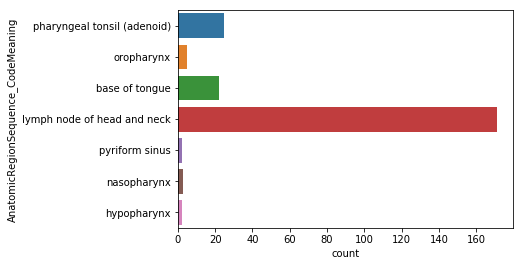

In [17]:
oneReaderOneSession = SEG_merged[SEG_merged["SeriesDescription"]=="tumor segmentation - User1 SemiAuto trial 1"]
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=oneReaderOneSession)
oneReaderOneSession["AnatomicRegionSequence_CodeMeaning"].value_counts()

Let's figure out how many structures were segmented in each of the studies. 

`SEG_merged` table has one row per segment, and each row contains `PatientID`, because of the way we constructed it. So we can just count the number of times each of the `PatientID`s is encountered.


In [18]:
SEG_merged["PatientID"].value_counts()

QIN-HEADNECK-01-0067    147
QIN-HEADNECK-01-0139    135
QIN-HEADNECK-01-0366    123
QIN-HEADNECK-01-0239    111
QIN-HEADNECK-01-0057    111
QIN-HEADNECK-01-0047    102
QIN-HEADNECK-01-0190     99
QIN-HEADNECK-01-0135     87
QIN-HEADNECK-01-0180     87
QIN-HEADNECK-01-0201     75
QIN-HEADNECK-01-0089     75
QIN-HEADNECK-01-0100     75
QIN-HEADNECK-01-0112     75
QIN-HEADNECK-01-0165     63
QIN-HEADNECK-01-0228     63
QIN-HEADNECK-01-0220     51
QIN-HEADNECK-01-0203     51
QIN-HEADNECK-01-0071     51
QIN-HEADNECK-01-0079     51
QIN-HEADNECK-01-0244     51
QIN-HEADNECK-01-0086     51
QIN-HEADNECK-01-0140     51
QIN-HEADNECK-01-0074     51
QIN-HEADNECK-01-0118     51
QIN-HEADNECK-01-0026     51
QIN-HEADNECK-01-0129     51
QIN-HEADNECK-01-0186     51
QIN-HEADNECK-01-0064     51
QIN-HEADNECK-01-0184     39
QIN-HEADNECK-01-0224     39
QIN-HEADNECK-01-0028     39
QIN-HEADNECK-01-0199     39
QIN-HEADNECK-01-0120     39
QIN-HEADNECK-01-0041     39
QIN-HEADNECK-01-0275     39
QIN-HEADNECK-01-0116

In [19]:
SEG_merged[SEG_merged["PatientID"] == "QIN-HEADNECK-01-0067"]["SeriesDescription"].value_counts()

tumor segmentation - User1 SemiAuto trial 2    12
tumor segmentation - User1 Manual trial 2      12
tumor segmentation - User3 Manual trial 1      12
tumor segmentation - User1 Manual trial 1      12
tumor segmentation - User1 SemiAuto trial 1    12
tumor segmentation - User3 SemiAuto trial 2    12
tumor segmentation - User2 Manual trial 1      12
tumor segmentation - User2 Manual trial 2      12
tumor segmentation - User2 SemiAuto trial 1    12
tumor segmentation - User3 SemiAuto trial 1    12
tumor segmentation - User2 SemiAuto trial 2    12
tumor segmentation - User3 Manual trial 2      12
auto cerebellum segmentation                    1
auto liver segmentation                         1
auto aorta segmentation                         1
Name: SeriesDescription, dtype: int64

# Segmentation-based measurements

In [20]:
SR_df = pd.read_csv(tablesPath+'/SR.tsv', sep='\t', low_memory=False)
SR1500_MeasurementGroups_df = pd.read_csv(tablesPath+'/SR1500_MeasurementGroups.tsv', sep='\t', low_memory=False)
SR1500_Measurements_df = pd.read_csv(tablesPath+'/SR1500_Measurements.tsv', sep='\t', low_memory=False)

In [21]:
SR_df.columns

Index(['CompletionFlag', 'SOPInstanceUID', 'TemplateIdentifier',
       'VerificationFlag'],
      dtype='object')

In [22]:
SR1500_MeasurementGroups_df.columns

Index(['DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'SOPInstanceUID', 'TrackingIdentifier', 'TrackingUniqueIdentifier',
       'activitySession', 'measurementMethod_CodeMeaning',
       'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [23]:
SR1500_Measurements_df.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator', 'value'],
      dtype='object')

Each finding is uniquely identified, so we can track measurements for the same finding done by different tools/readers, or over longitudinally over the period of time.

In [24]:
SR1500_MeasurementGroups_df["TrackingUniqueIdentifier"].value_counts()

2.25.333657797761921037156281860379899803564    12
2.25.103079984808902877894036258209407121324    12
2.25.127380548125105356744175330995772274604    12
2.25.329496109556469636600245319046484932524    12
2.25.97540606008307186198019340477994579884     12
2.25.43456499935073941013083617370337916844     12
2.25.8928973669376936946672915098242070444      12
2.25.45524878674850459511546607799619237804     12
2.25.2942848651967187502337153287751415724      12
2.25.4843844429644695162696391219476379564      12
2.25.324064553154521232383902831212524156844    12
2.25.115988184857360261395218474256090216364    12
2.25.74485136242183500549820712998905264044     12
2.25.318774060119084600392715520575818119084    12
2.25.141738288412446342285171380642694248364    12
2.25.147175344833436486731829612297687349164    12
2.25.16392508224116306054214415528941795244     12
2.25.130838263999915763240244948783750657964    12
2.25.26204673713330650616301797533567367084     12
2.25.10518225181063162267761813

Note that `SOPInstanceUID` is attached to every item to link to the DICOM instance where it comes from. `TrackingUniqueIdentifier` is unique for every structure being segmented, and comes up 12 times for each finding that is not a reference region: had 3 users, with each user segmenting the same structure using manual or semi-automatic approaches, on 2 occasions - 3x2x2 = 12.

Since measurements for the segmentations produced using each combination of user/segmentation method/segmentation session is stored into a separate series, we can uniquely match attributes of the MeasurementGroup with the individual measurements by merging on the combination of `SOPInstanceUID` and `TrackingUniqueIdentifier` keys.

In [25]:
SR_merged = pd.merge(SR1500_Measurements_df,SR1500_MeasurementGroups_df,on=["SOPInstanceUID","TrackingUniqueIdentifier"])
SR_merged.shape

(12891, 24)

In [26]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator', 'value',
       'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [27]:
SR_merged["PersonObserverName"].value_counts()

User3    4072
User2    4054
User1    4045
User4      24
User5       4
Name: PersonObserverName, dtype: int64

Didn't expect to see `User4` and `User5` ... what are they?

In [28]:
SR_merged[SR_merged["PersonObserverName"].isin(["User4","User5"])]["FindingSite_CodeMeaning"]

472      Aortic arch
473      Aortic arch
474      Aortic arch
475      Aortic arch
1514           Liver
1515           Liver
1516           Liver
1517           Liver
7605     Aortic arch
7606     Aortic arch
7607     Aortic arch
7608     Aortic arch
7609      Cerebellum
7610      Cerebellum
7611      Cerebellum
7612      Cerebellum
7849      Cerebellum
7850      Cerebellum
7851      Cerebellum
7852      Cerebellum
12194    Aortic arch
12195    Aortic arch
12196    Aortic arch
12197    Aortic arch
12198     Cerebellum
12199     Cerebellum
12200     Cerebellum
12201     Cerebellum
Name: FindingSite_CodeMeaning, dtype: object

Now let's add all of the composite context information so that we know what patient each measurement belongs to.

In [29]:
SR_merged=pd.merge(SR_merged, CompositeContext_df, on="SOPInstanceUID")
SR_merged.shape

(12891, 42)

In [30]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator', 'value',
       'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint',
       'BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID',
       'SeriesTime', 'SoftwareVersions', 'StudyDate', 'StudyDesc

## Plot measurements

Each finding was expected to be segmented by each of the 3 users, using automated or manual approach, two times each (12 segmentations total). Each finding is assigned a unique identifier, so we can look at the consistency of the segmentation across readers, across segmentation approaches, and across segmentation sessions.

But first, let's check and confirm that we have all 12 sets of measurements for each of the unique tracking identifier. Let's only consider primary and secondary neoplasms.



In [31]:
SR_merged["Finding_CodeMeaning"].unique()

array(['Reference Region', 'Neoplasm, Primary', 'Neoplasm, Secondary'], dtype=object)

In [32]:
SR_merged.groupby(['quantity_CodeMeaning','derivationModifier_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,derivationModifier_CodeMeaning,count
0,SUVbw,Maximum,2940
1,SUVbw,Mean,2940
2,SUVbw,Minimum,2940
3,SUVbw,Peak Value Within ROI,1131


In [33]:
SR_merged.groupby(['quantity_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,count
0,SUVbw,9951
1,Volume,2940


In [34]:
SR_merged["quantity_CodeMeaning"].unique()

array(['SUVbw', 'Volume'], dtype=object)

In [35]:
SR_merged["derivationModifier_CodeMeaning"].unique()

array(['Mean', 'Minimum', 'Maximum', nan, 'Peak Value Within ROI'], dtype=object)

Observe how for some measurements we have 12 items for a given finding type (and there is always Primary tumor present):

Since we have volume of the primary tumor available for every subject, let's see how much it varies across users, tools and segmentation sessions.

In [36]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["quantity_CodeMeaning"]=="Volume"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


59.0

... and for others less than that, since some of the measurements cannot always be computed!

In [37]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["derivationModifier_CodeMeaning"]=="Peak Value Within ROI"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


46.916666666666664

Since we have volume of the primary tumor available for every subject, let's see how much it varies across users, tools and segmentation sessions. Lets factor out the segmentation tool type. Note that the segmentation tool type is encoded directly in the SEG objects, but it is more convenient to take it from the series description of the SR objects storing the measurements.

In [38]:
SR_merged["segmentationToolType"] = \
 SR_merged["SeriesDescription"].apply(lambda toolType: toolType.split(" ")[-3] if toolType.split(" ")[-3] in ["Manual","SemiAuto"] else "Auto")
SR_merged["segmentationToolType"]

0            Auto
1            Auto
2            Auto
3            Auto
4            Auto
5            Auto
6            Auto
7            Auto
8            Auto
9            Auto
10           Auto
11           Auto
12         Manual
13         Manual
14         Manual
15         Manual
16         Manual
17         Manual
18         Manual
19         Manual
20         Manual
21         Manual
22       SemiAuto
23       SemiAuto
24       SemiAuto
25       SemiAuto
26       SemiAuto
27       SemiAuto
28       SemiAuto
29       SemiAuto
           ...   
12861    SemiAuto
12862    SemiAuto
12863    SemiAuto
12864    SemiAuto
12865    SemiAuto
12866    SemiAuto
12867    SemiAuto
12868    SemiAuto
12869    SemiAuto
12870    SemiAuto
12871    SemiAuto
12872    SemiAuto
12873    SemiAuto
12874    SemiAuto
12875    SemiAuto
12876    SemiAuto
12877    SemiAuto
12878    SemiAuto
12879    SemiAuto
12880    SemiAuto
12881    SemiAuto
12882    SemiAuto
12883    SemiAuto
12884    SemiAuto
12885    S

First load the references

In [39]:
References_df=pd.read_csv(tablesPath+'/References.tsv', sep='\t', low_memory=False)
References_df.columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID'],
      dtype='object')

In [40]:
References_df.shape

(316629, 4)

In [41]:
References_df[References_df["SOPInstanceUID"]=="1.2.276.0.7230010.3.1.4.8323329.18258.1440001306.617244"]["SeriesInstanceUID"].unique()

array(['1.3.6.1.4.1.14519.5.2.1.2744.7002.261560220703676715130542397405',
       '1.2.276.0.7230010.3.1.4.8323329.18215.1440001297.928456',
       '1.2.276.0.7230010.3.1.3.8323329.18234.1440001306.224430'], dtype=object)

In [42]:
# WIP: do not run this!
series_df=CompositeContext_df.drop_duplicates(subset="SeriesInstanceUID")

# All references to SEG (only Measurements point to SEG in our case, 
#  and each SR should point to exactly one SEG!)
segReferences = References_df[References_df["ReferencedSOPClassUID"]=='1.2.840.10008.5.1.4.1.1.66.4']
segReferences = segReferences[["SOPInstanceUID","SeriesInstanceUID"]].rename(columns={"SeriesInstanceUID":"ReferencedSeriesInstanceUID"})
segReferences.shape

(900, 2)

In [43]:
References_df.shape
CompositeContext_df.shape

(353252, 19)

In [46]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool

output_notebook()

volume = []
user = []
method = []
sesssion = []
subject = []

SR_merged = pd.merge(SR_merged, segReferences)


subset = SR_merged[SR_merged["PersonObserverName"]=="User1"]
subset = subset[subset["Finding_CodeMeaning"]=="Neoplasm, Primary"]
subset = subset[subset["quantity_CodeMeaning"]=="Volume"]
#subset = subset[subset["activitySession"]==1]
#subset = subset[subset["segmentationToolType"]=="SemiAuto"]

#subset.sort_values("value", inplace=True)

#subset=subset[subset["PatientID"]=="QIN-HEADNECK-01-0003"]

Loading BokehJS ...

In [45]:


volumes = subset["value"].values
observers = subset["PersonObserverName"].values
subjects = subset["PatientID"].values

subset["segmentationToolType"].unique()

colormap = {'1-Manual': 'red', '2-Manual': 'red', '1-SemiAuto': 'blue', '2-SemiAuto': 'blue'}
colors = [colormap[x] for x in (subset["activitySession"].map(str)+'-'+subset['segmentationToolType']).tolist()]

source = ColumnDataSource(data=dict(
    x=volumes,
    y=subjects,
    color=colors,
    seriesUID=subset["ReferencedSeriesInstanceUID"]
    ))

hover = HoverTool(tooltips=[
    ("(Volume, Subject)", "($x, $y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

p = figure(x_range=[np.min(volumes),np.max(volumes)],y_range=subjects.tolist(), tools = [hover, wZoom, bZoom, reset, tap, pan],title="Volume segmentation consistency by User1; manual (red circles) and SemiAutomatic (blue circles)")
#p.yaxis.axis_label = "PatientID"
#p.xaxis.axis_label = subset["quantity_CodeMeaning"].values[0]+', '+subset['units_CodeMeaning'].values[0]

p.circle('x','y',color='color',source=source)

url = "http://pieper.github.com/dcmjs/examples/qiicr/?seriesUID=@seriesUID"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)